In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23',)

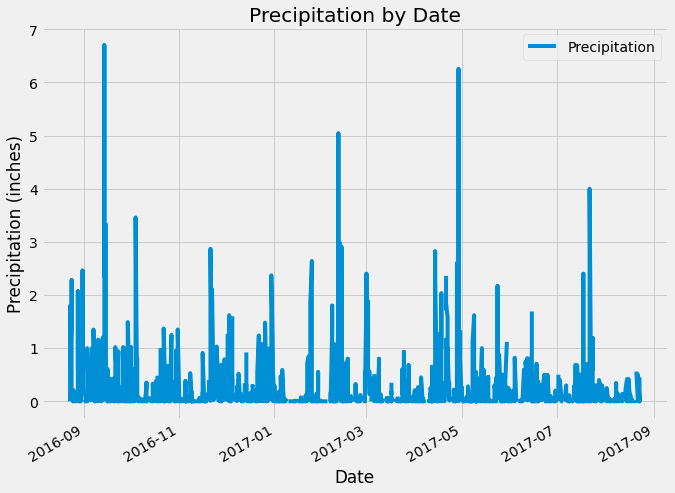

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
date = dt.datetime(2017, 8, 23)

# Calculate the date one year from the last date in data set - 2016 was a leap year
recent_year = date - dt.timedelta(days = 366)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= recent_year).order_by(Measurement.date).all()

#Save date and precipitation data in lists
date = [result[0] for result in results]
precipitation = [result[1] for result in results]

# Save the query results as a Pandas DataFrame and set the index to the date column
precip = pd.DataFrame({"Date": date,
                      "Precipitation": precipitation})

#Convert date column to datetime
precip["Date"]= pd.to_datetime(precip["Date"])

#Set date column as index
precip_df = precip.set_index("Date")

# Sort the dataframe by date
precip_df = precip_df.sort_values("Date") 

# Use Pandas Plotting with Matplotlib to plot the data
ax = precip_df.plot(figsize =(10, 8))
plt.title("Precipitation by Date")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.grid(True)
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(Station.station).count()
stations

9

In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?) - in descending order
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

# List the stations and the counts
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
#Find the most active station id
most_active_station = (active_stations[0])[0]

#Query to find the highest, lowest, and average temperature
temp = session.query(func.max(Measurement.tobs), func.min(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

#Print results
print(f'The highest, lowest, and average temperatures are: {temp}')

The highest, lowest, and average temperatures are: [(85.0, 54.0, 71.66378066378067)]


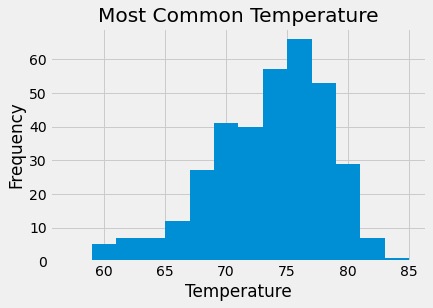

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station
year_temp = pd.DataFrame((session.query(Measurement.tobs).\
    filter(Measurement.date >= recent_year).\
    filter(Measurement.station == most_active_station).all()), columns = ["Temperature"])

#Plot histogram for most common temperature
bins = 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85
plt.hist(year_temp, bins = bins)
plt.title("Most Common Temperature")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

# Close session

In [16]:
# Close Session
session.close()